# CE-40550 Machine Learning for Bioinformatics (55 + 20 points)
## Deadline: 30th Ordibehesht

# Task description

Gene expression profile is the measurement of the activity (the expression) of thousands of genes in a sample. The internal patterns of the GEPs such as coexpression of large clusters of genes suggest that the dimensionality of GEPs can be significantly reduced. We are going to use a variety of dimension reduction techniques to see if this can really be accomplished, and to compare these techniques' suitability for this task.

For the purpose of this homework, we consider the reconstruction mean squared error as the measure to compare different methods. In other words, For each method, we first reduce the dimension and then try to reconstruct the input using the reduced data. Finally we compute MSE between the reconstructed and original data and use it as the measure to compare methods for the task at hand.

We will use a latent space of dimension 30.

In [0]:
# Load data from google drive

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('')
try:
  os.makedirs(local_download_path)
except: pass

# Download a file based on its file ID.
file_id = '1vcBzIMtv_cvQ63jfVCbTQQ-v9thmCLRS'
downloaded = drive.CreateFile({'id': file_id})
fname = os.path.join(local_download_path, downloaded['title'])
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

print('title: %s, id: %s' % (downloaded['title'], downloaded['id']))
downloaded.GetContentFile(fname)
print(fname)
!unzip "dataset.zip"

In [0]:
import pandas as pd
import numpy as np

# Load data

You may download the dataset from <a href="https://drive.google.com/open?id=1vcBzIMtv_cvQ63jfVCbTQQ-v9thmCLRS">here</a>. `data.txt` contains normalized expression profiles of 20184 genes in 1040 samples of 16 different human tissues and cell types from different datasets of NCBI GEO, which were collected and preprocessed in CellNet. `SampleCellTypes.txt` contains the type of the cell samples present in `data.txt`.

Extract the downloaded data and then use the code below to load it.

In [0]:
data = pd.read_csv("data/data.txt", header=None)
labels = pd.read_csv("data/SampleCellTypes.txt", header=None)

# Variable selection

To reduce the computation costs, instead of working on all 20184 genes present in the dataset, we will focus on 1000 genes that have the most variance.

In [40]:
# TODO: limited_data should contain columns of data corresponding to genes with most variance
limited_data = None
n_features = 1000

from sklearn.feature_selection import VarianceThreshold

# find variance of features
selector = VarianceThreshold()
selector.fit_transform(data)
vars = selector.variances_
var_threshold = sorted(vars)[-(n_features + 1)]


def variable_selection(data, threshold):
    selector = VarianceThreshold(threshold)
    return selector.fit_transform(data)

limited_data = variable_selection(data, var_threshold)
print(data.shape)
print(limited_data.shape)

(1040, 20184)
(1040, 1000)


# Data preperation

You may use existing libraries to complete the following two tasks:

In [0]:
# TODO: Split the data to train and test with a ratio of 3:1.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

train_dataset = None
test_dataset = None

onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(labels).toarray()
n_classes = np.size(y, axis=1)

X_train, X_test, y_train, y_test = train_test_split(limited_data, y, test_size=0.25, random_state=42)

In [0]:
# TODO: Implement a function that given the original data and a
# reconstructed version, returns the reconstruction's mean squared error.
def loss_function(a, b):
    return np.square(np.linalg.norm(a - b, ord='fro')) / np.prod(a.shape)

# PCA

Implement PCA. Then use it to project the data to the latent space. Finally, reconstruct the data and report the reconstruction error for both training and test datasets. Note that you should implement the PCA, so using existing libraries is not allowed. However you may use libraries to compute eigenvectors/eigenvalues of a matrix.

In [0]:
# TODO: Implement the following method
def PCA(X, mean, var, n_components=30):
    """
        X: a vector of shape (N, M)
        n_components: size of latent space (< M)
        returns a vector of shape (n_components, M) containing the first `n_components` PCs.
    """
    
    N, M = X.shape
    
    # zero mean
#     X = (X - X.mean(axis=0)) / X.std(axis=0)
    X = (X - mean) / var
    
    # compute covariance matrix
    C = np.dot(X.T, X)
    
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    idx = np.argsort(eigen_vals)[::-1][:n_components]
    eigen_vecs = eigen_vecs[:,idx]
    
    return eigen_vecs.T

In [0]:
def reconstruct_PCA(X, mean=None, var=None):
  
    # TODO: Compute PCs for the X.
    principal_components = PCA(X, mean=mean, var=var)

    # TODO: Project X to the space of computed PCs.
    X = (X - mean) / var
    projected_data = np.dot(X, principal_components.T)

    # TODO: Reconstruct X from projected data.
    reconstructed_data = np.dot(projected_data, principal_components) * var + mean
    
    return reconstructed_data

In [63]:
# TODO: Reconstruct train and test data and compute reconstruction error
train_pca_error = None
test_pca_error = None

mean = X_train.mean(axis=0)
var = X_train.std(axis=0)

train_pca_error = loss_function(X_train, reconstruct_PCA(X_train, mean=mean, var=var))
test_pca_error = loss_function(X_test, reconstruct_PCA(X_test, mean=mean, var=var))

print("Train error: %f" % train_pca_error)
print("Test error: %f" % test_pca_error)

Train error: 0.366957
Test error: 0.291576


# Auto Encoders

Implement auto encoder with following encoder architecture using keras.
```
Dense(400) with LogSigmoid as activation.
Dense(30)
```
Use symmetric layers as decoder to reconstruct the input.

In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import optimizers

In [44]:
input_data = Input(shape=(1000,))

encoded = input_data
# TODO: Implement encoder
encoded = Dense(400, activation=tf.math.log_sigmoid)(encoded)
encoded = Dense(30)(encoded)

decoded = encoded
# TODO: Implement decoder
decoded = Dense(400, activation=tf.math.log_sigmoid)(decoded)
decoded = Dense(1000, activation='sigmoid')(decoded)

autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 400)               400400    
_________________________________________________________________
dense_14 (Dense)             (None, 30)                12030     
_________________________________________________________________
dense_15 (Dense)             (None, 400)               12400     
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              401000    
Total params: 825,830
Trainable params: 825,830
Non-trainable params: 0
_________________________________________________________________


In [0]:
# TODO: find suitable values for hyperparameters
learning_rate = 0.1
epochs = 500
batch_size = 16

In [0]:
# autoencoder = Model(input_data, decoded)
sgd = optimizers.SGD(lr=learning_rate)
autoencoder.compile(optimizer=sgd, loss='mean_squared_error')

mean = X_train.mean(axis=0)
var = X_train.std(axis=0)
X_train_scaled = (X_train - mean) / var
X_test_scaled = (X_test - mean) / var

In [51]:
# TODO: fit your model here

history = autoencoder.fit(X_train_scaled, X_train_scaled, 
                          epochs=epochs, 
                          batch_size=batch_size, 
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

Train on 624 samples, validate on 156 samples
Epoch 1/500
624/624 [==============================] - 0s 557us/step - loss: 0.7181 - val_loss: 0.7072
Epoch 2/500
624/624 [==============================] - 0s 555us/step - loss: 0.7171 - val_loss: 0.7063
Epoch 3/500
624/624 [==============================] - 0s 540us/step - loss: 0.7161 - val_loss: 0.7054
Epoch 4/500
624/624 [==============================] - 0s 554us/step - loss: 0.7153 - val_loss: 0.7045
Epoch 5/500
624/624 [==============================] - 0s 586us/step - loss: 0.7144 - val_loss: 0.7034
Epoch 6/500
624/624 [==============================] - 0s 604us/step - loss: 0.7136 - val_loss: 0.7029
Epoch 7/500
624/624 [==============================] - 0s 592us/step - loss: 0.7127 - val_loss: 0.7018
Epoch 8/500
624/624 [==============================] - 0s 621us/step - loss: 0.7116 - val_loss: 0.7010
Epoch 9/500
624/624 [==============================] - 0s 625us/step - loss: 0.7108 - val_loss: 0.7002
Epoch 10/500
624/624 [=====

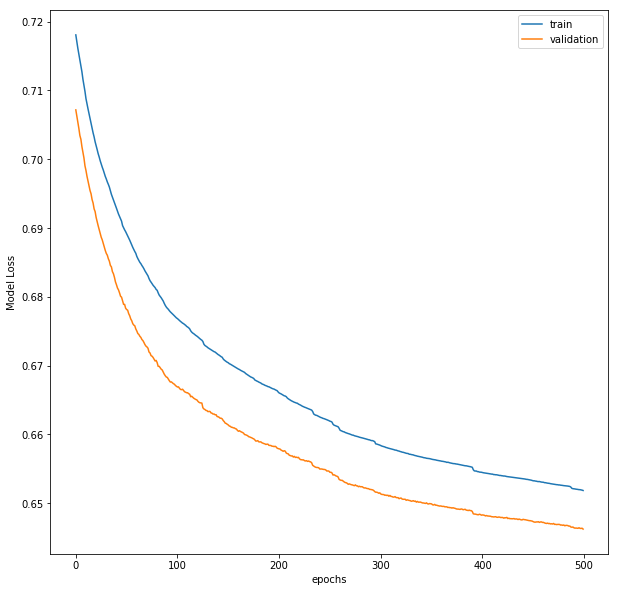

In [52]:
import matplotlib.pyplot as plt

# TODO: Plot learning curve of the model
def plot_history(history):
    plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('epochs'), plt.ylabel('Model Loss')
    plt.legend(), plt.show()
    
plot_history(history)

In [53]:
# TODO: compute reconstruction error
rec_train = autoencoder.predict(X_train_scaled) * var + mean
train_ae_error = loss_function(X_train, rec_train)

rec_test = autoencoder.predict(X_test_scaled) * var + mean
test_ae_error = loss_function(X_test, rec_test)

print("Train error: %f" % train_ae_error)
print("Test error: %f" % test_ae_error)

Train error: 2.574618
Test error: 2.533422


# Bonus: Classification accuracy

As you already know, there is more than one way to project a data of high dimension to a latent space of reduced dimension. When trying to find a model which can reconstruct the input effectively, the latent data should be able to encode as much data in the input as possible. However, when you are trying to use the latent data for classifying, most likely you don't care if all the data in the input is present. Rather, you only care about relevant data.

Create a classifier neural network which takes the output of your encoder as input and predicts its label. Connect this to your model so your architecture looks like the figure below. Train your neural network and report your classification accuracy

<center><img src="images/bonus.png" width="20%"/></center>

In [54]:
input_data = Input(shape=(1000,))

# encoder
encoded = input_data
encoded = Dense(800, activation='relu')(encoded)
encoded = Dense(400, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)

# classifier
fc = Dense(80,  activation='relu')(encoded)
fc = Dense(30,  activation='relu')(fc)
softmax = Dense(n_classes, activation='softmax', name='classifier')(fc)

# decoder
decoded = encoded
encoded = Dense(100)(encoded)
decoded = Dense(400, activation='relu')(decoded)
encoded = Dense(800, activation='relu')(encoded)
decoded = Dense(1000, activation='sigmoid', name='autoencoder')(decoded)

model = Model(inputs=input_data, outputs=[softmax, decoded])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 800)          800800      input_4[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 400)          320400      dense_17[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 100)          40100       dense_18[0][0]                   
__________________________________________________________________________________________________
dense_20 (

In [55]:
adam = optimizers.Adam(lr=learning_rate)
model.compile(loss={'classifier': 'categorical_crossentropy', 'autoencoder': 'mse'},
              optimizer='adam',
              metrics={'classifier': 'acc'})

history = model.fit(X_train_scaled, 
                    {'classifier': y_train, 'autoencoder': X_train_scaled},
                    batch_size=batch_size,
                    epochs=100,
                    validation_split=0.2, 
                    verbose=1)

Train on 624 samples, validate on 156 samples
Epoch 1/100
624/624 [==============================] - 2s 3ms/step - loss: 1.5262 - classifier_loss: 0.5604 - autoencoder_loss: 0.9658 - classifier_acc: 0.8750 - val_loss: 1.0615 - val_classifier_loss: 0.2427 - val_autoencoder_loss: 0.8188 - val_classifier_acc: 0.9103
Epoch 2/100
624/624 [==============================] - 1s 2ms/step - loss: 0.8550 - classifier_loss: 0.1010 - autoencoder_loss: 0.7540 - classifier_acc: 0.9776 - val_loss: 0.8480 - val_classifier_loss: 0.1634 - val_autoencoder_loss: 0.6846 - val_classifier_acc: 0.9615
Epoch 3/100
624/624 [==============================] - 1s 2ms/step - loss: 0.7069 - classifier_loss: 0.0422 - autoencoder_loss: 0.6647 - classifier_acc: 0.9952 - val_loss: 0.6375 - val_classifier_loss: 9.0369e-04 - val_autoencoder_loss: 0.6366 - val_classifier_acc: 1.0000
Epoch 4/100
624/624 [==============================] - 1s 2ms/step - loss: 0.6618 - classifier_loss: 0.0264 - autoencoder_loss: 0.6355 - classi

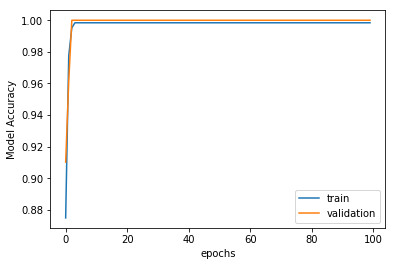

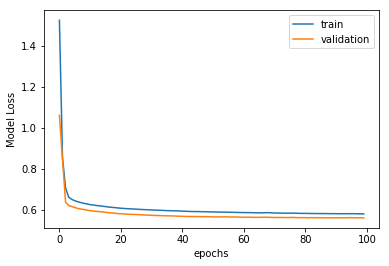

In [59]:
# plot the learning curve

def plot_history(history):
    plt.figure()
    plt.plot(history.history['classifier_acc'], label='train')
    plt.plot(history.history['val_classifier_acc'], label='validation')
    plt.xlabel('epochs'), plt.ylabel('Model Accuracy')
    plt.legend(), plt.show()
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('epochs'), plt.ylabel('Model Loss')
    plt.legend(), plt.show()
    
plot_history(history)

In [60]:
train_acc = model.evaluate(X_train_scaled, {'classifier': y_train, 'autoencoder': X_train_scaled})
test_acc = model.evaluate(X_test_scaled, {'classifier': y_test, 'autoencoder': X_test_scaled})

print("Train accuracy: {}".format(train_acc[3]))
print("Test accuracy: {}".format(test_acc[3]))

260/260 [==============================] - 0s 227us/step
Train accuracy: 0.9987179487179487
Test accuracy: 0.9961538461538462
